In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 18

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
runs = [304125,302263,304508]
with open("pileup_dataNotNorm.pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1
num_parts = 6

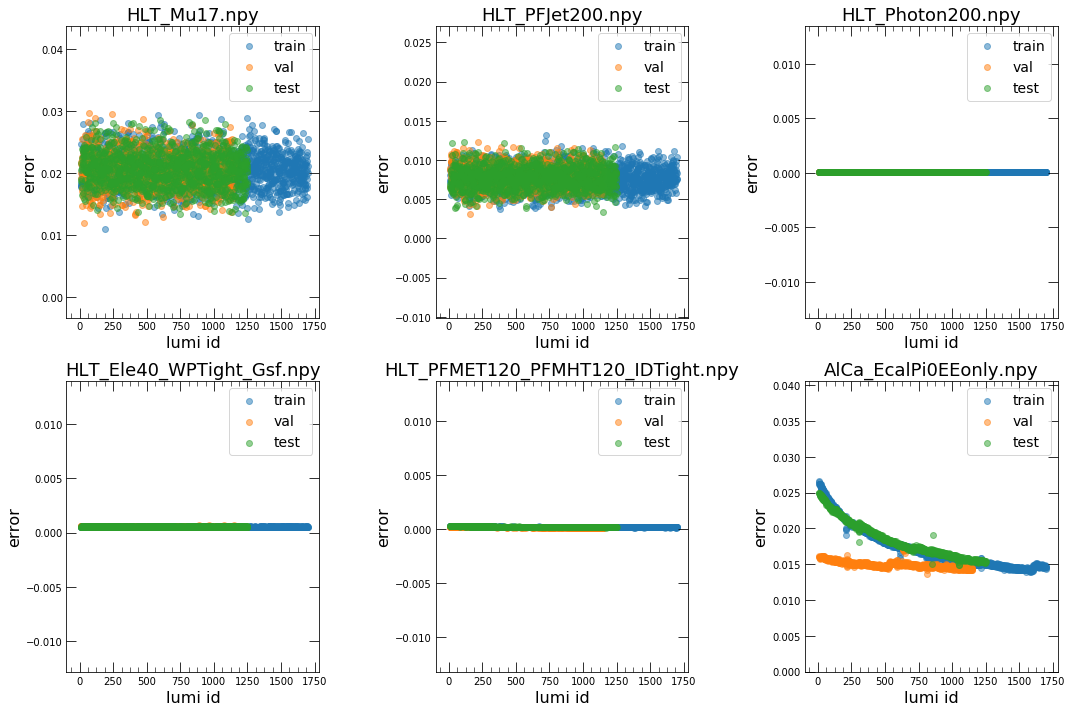

In [6]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

In [7]:
runs = [304125,304508,302263]

with open('pileup_dataNotNorm.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileup_bad_dataNotNorm.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad = np.array(bad_data['301480']['samples'])

WINDOW = 1

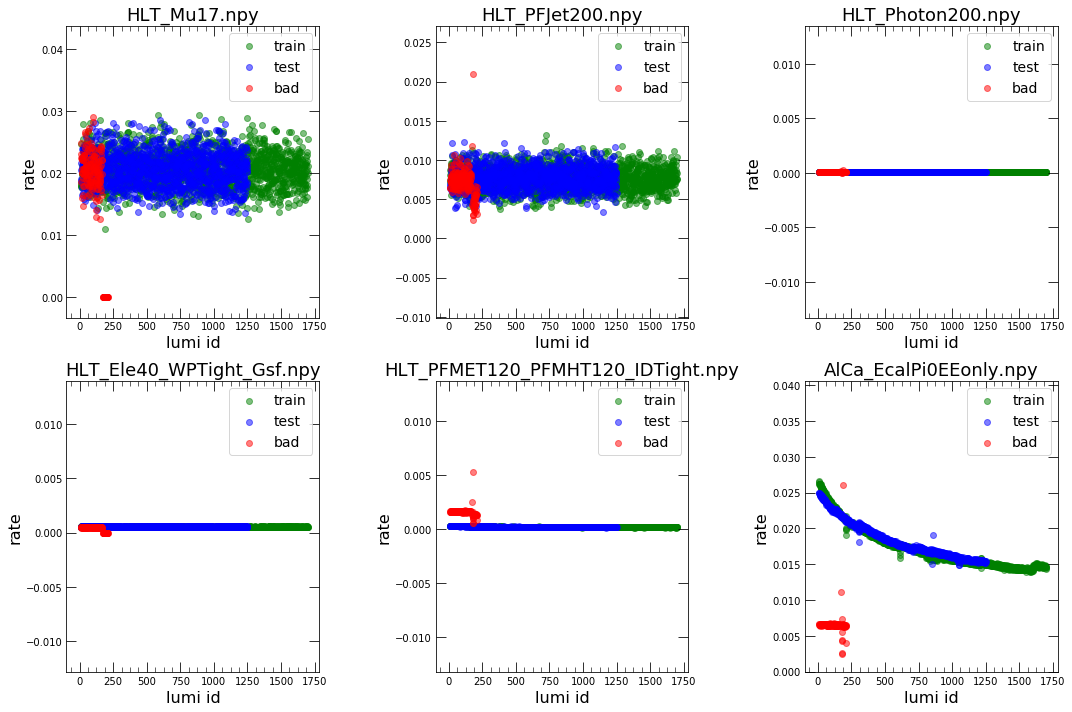

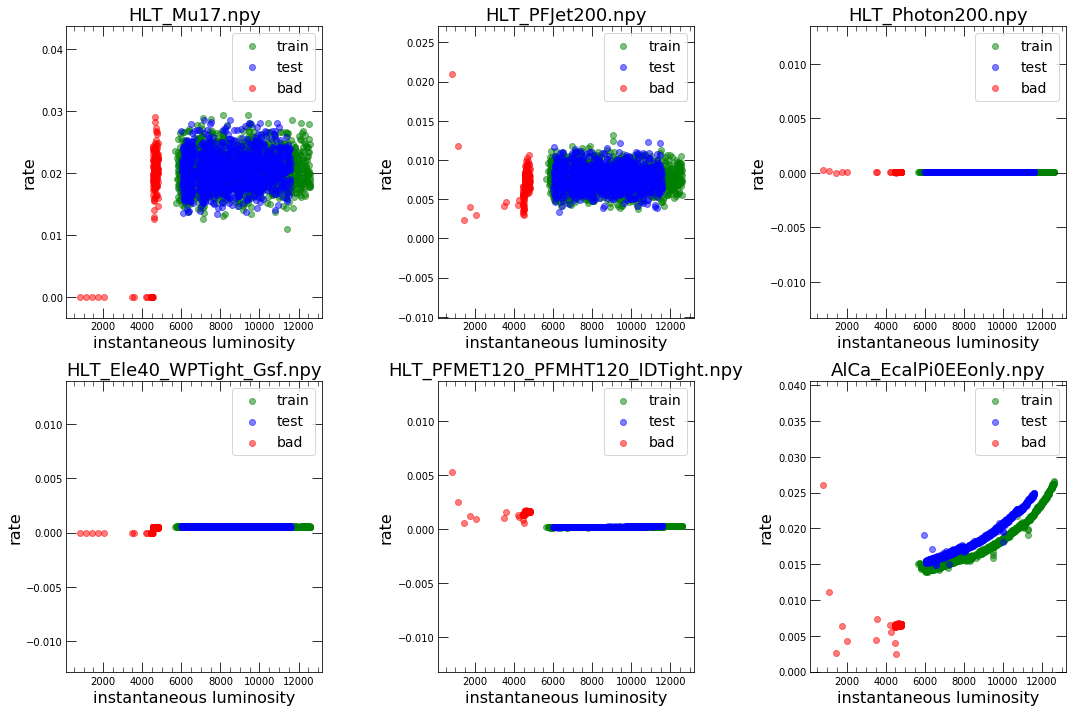

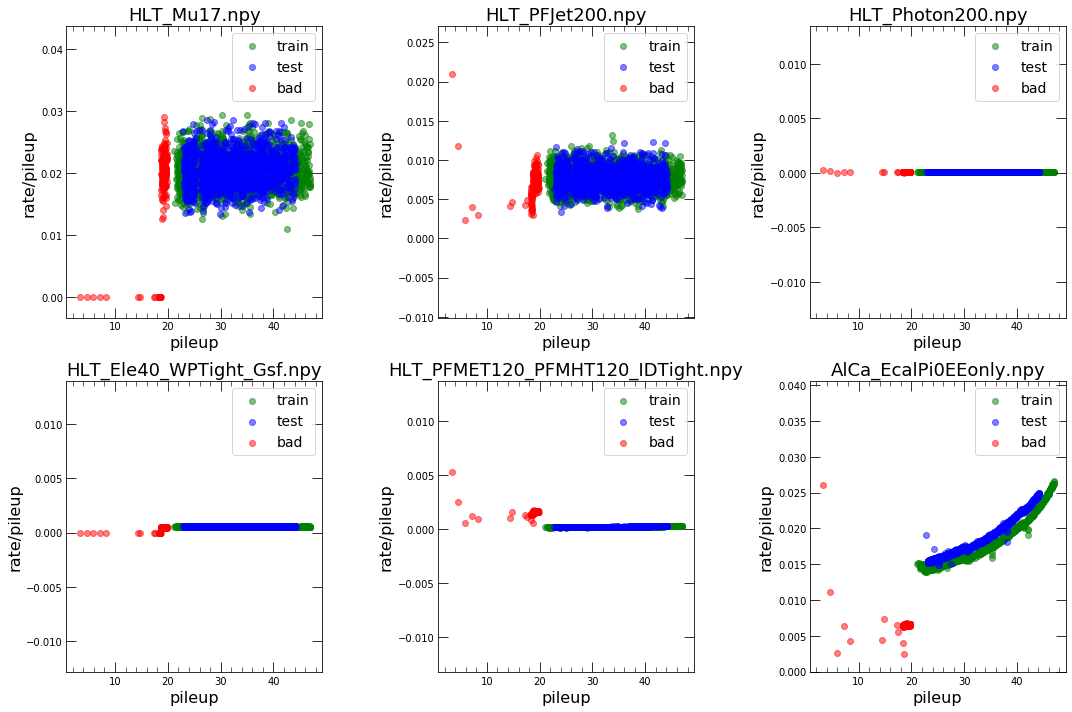

In [8]:
plots = [x_train,x_test,x_bad]
titles = ["train","test","bad"]

stuff = [[],[],[]]
lumi = [[],[],[]]
inst = [[],[],[]]
pileup = [[],[],[]]
for h in range(3):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    else:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r"]
    
plt.figure(figsize=[15,10])
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate/pileup')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [9]:
model_name = "bottleneck"


In [10]:
# Define the architecture

_input = Input(shape=(num_parts*WINDOW,), name="input")

hidden = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(num_parts*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
encoded (Dense)              (None, 4)                 28        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 30        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 0s - loss: 0.0318 - val_loss: 0.0329
Epoch 2/1000
 - 0s - loss: 0.0310 - val_loss: 0.0321
Epoch 3/1000
 - 0s - loss: 0.0303 - val_loss: 0.0313
Epoch 4/1000
 - 0s - loss: 0.0296 - val_loss: 0.0305
Epoch 5/1000
 - 0s - loss: 0.0288 - val_loss: 0.0297
Epoch 6/1000
 - 0s - loss: 0.0281 - val_loss: 0.0290
Epoch 7/1000
 - 0s - loss: 0.0274 - val_loss: 0.0283
Epoch 8/1000
 - 0s - loss: 0.0267 - val_loss: 0.0275
Epoch 9/1000
 - 0s - loss: 0.0260 - val_loss: 0.0268
Epoch 10/1000
 - 0s - loss: 0.0254 - val_loss: 0.0262
Epoch 11/1000
 - 0s - loss: 0.0247 - val_loss: 0.0255
Epoch 12/1000
 - 0s - loss: 0.0241 - val_loss: 0.0248
Epoch 13/1000
 - 0s - loss: 0.0235 - val_loss: 0.0242
Epoch 14/1000
 - 0s - loss: 0.0229 - val_loss: 0.0236
Epoch 15/1000
 - 0s - loss: 0.0223 - val_loss: 0.0230
Epoch 16/1000
 - 0s - loss: 0.0217 - val_loss: 0.0224
Epoch 17/1000
 - 0s - loss: 0.0212 - val_loss: 0.0218
Epoch 18/1000
 - 0s - loss: 0.0206 - val_lo

Epoch 152/1000
 - 0s - loss: 0.0014 - val_loss: 0.0015
Epoch 153/1000
 - 0s - loss: 0.0014 - val_loss: 0.0015
Epoch 154/1000
 - 0s - loss: 0.0014 - val_loss: 0.0015
Epoch 155/1000
 - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 156/1000
 - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 157/1000
 - 0s - loss: 0.0013 - val_loss: 0.0014
Epoch 158/1000
 - 0s - loss: 0.0013 - val_loss: 0.0014
Epoch 159/1000
 - 0s - loss: 0.0013 - val_loss: 0.0014
Epoch 160/1000
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 161/1000
 - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 162/1000
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 163/1000
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 164/1000
 - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 165/1000
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 166/1000
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 167/1000
 - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 168/1000
 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 169/1000
 - 0s - loss: 0.0011 - val_loss: 0.0012
Epoch 170/

Epoch 286/1000
 - 0s - loss: 2.7753e-04 - val_loss: 2.8948e-04
Epoch 287/1000
 - 0s - loss: 2.7472e-04 - val_loss: 2.8656e-04
Epoch 288/1000
 - 0s - loss: 2.7196e-04 - val_loss: 2.8368e-04
Epoch 289/1000
 - 0s - loss: 2.6923e-04 - val_loss: 2.8083e-04
Epoch 290/1000
 - 0s - loss: 2.6653e-04 - val_loss: 2.7802e-04
Epoch 291/1000
 - 0s - loss: 2.6387e-04 - val_loss: 2.7524e-04
Epoch 292/1000
 - 0s - loss: 2.6124e-04 - val_loss: 2.7250e-04
Epoch 293/1000
 - 0s - loss: 2.5864e-04 - val_loss: 2.6979e-04
Epoch 294/1000
 - 0s - loss: 2.5608e-04 - val_loss: 2.6712e-04
Epoch 295/1000
 - 0s - loss: 2.5354e-04 - val_loss: 2.6448e-04
Epoch 296/1000
 - 0s - loss: 2.5105e-04 - val_loss: 2.6187e-04
Epoch 297/1000
 - 0s - loss: 2.4858e-04 - val_loss: 2.5929e-04
Epoch 298/1000
 - 0s - loss: 2.4614e-04 - val_loss: 2.5675e-04
Epoch 299/1000
 - 0s - loss: 2.4373e-04 - val_loss: 2.5423e-04
Epoch 300/1000
 - 0s - loss: 2.4134e-04 - val_loss: 2.5175e-04
Epoch 301/1000
 - 0s - loss: 2.3899e-04 - val_loss: 2.4

Epoch 417/1000
 - 0s - loss: 8.9048e-05 - val_loss: 9.2806e-05
Epoch 418/1000
 - 0s - loss: 8.8391e-05 - val_loss: 9.2121e-05
Epoch 419/1000
 - 0s - loss: 8.7742e-05 - val_loss: 9.1442e-05
Epoch 420/1000
 - 0s - loss: 8.7098e-05 - val_loss: 9.0769e-05
Epoch 421/1000
 - 0s - loss: 8.6461e-05 - val_loss: 9.0103e-05
Epoch 422/1000
 - 0s - loss: 8.5829e-05 - val_loss: 8.9443e-05
Epoch 423/1000
 - 0s - loss: 8.5203e-05 - val_loss: 8.8789e-05
Epoch 424/1000
 - 0s - loss: 8.4583e-05 - val_loss: 8.8142e-05
Epoch 425/1000
 - 0s - loss: 8.3969e-05 - val_loss: 8.7500e-05
Epoch 426/1000
 - 0s - loss: 8.3362e-05 - val_loss: 8.6865e-05
Epoch 427/1000
 - 0s - loss: 8.2759e-05 - val_loss: 8.6235e-05
Epoch 428/1000
 - 0s - loss: 8.2162e-05 - val_loss: 8.5611e-05
Epoch 429/1000
 - 0s - loss: 8.1571e-05 - val_loss: 8.4994e-05
Epoch 430/1000
 - 0s - loss: 8.0985e-05 - val_loss: 8.4382e-05
Epoch 431/1000
 - 0s - loss: 8.0406e-05 - val_loss: 8.3776e-05
Epoch 432/1000
 - 0s - loss: 7.9831e-05 - val_loss: 8.3

 - 0s - loss: 3.7891e-05 - val_loss: 3.9563e-05
Epoch 548/1000
 - 0s - loss: 3.7666e-05 - val_loss: 3.9330e-05
Epoch 549/1000
 - 0s - loss: 3.7443e-05 - val_loss: 3.9098e-05
Epoch 550/1000
 - 0s - loss: 3.7221e-05 - val_loss: 3.8867e-05
Epoch 551/1000
 - 0s - loss: 3.7001e-05 - val_loss: 3.8639e-05
Epoch 552/1000
 - 0s - loss: 3.6783e-05 - val_loss: 3.8412e-05
Epoch 553/1000
 - 0s - loss: 3.6566e-05 - val_loss: 3.8187e-05
Epoch 554/1000
 - 0s - loss: 3.6350e-05 - val_loss: 3.7963e-05
Epoch 555/1000
 - 0s - loss: 3.6136e-05 - val_loss: 3.7741e-05
Epoch 556/1000
 - 0s - loss: 3.5925e-05 - val_loss: 3.7521e-05
Epoch 557/1000
 - 0s - loss: 3.5714e-05 - val_loss: 3.7302e-05
Epoch 558/1000
 - 0s - loss: 3.5504e-05 - val_loss: 3.7085e-05
Epoch 559/1000
 - 0s - loss: 3.5296e-05 - val_loss: 3.6869e-05
Epoch 560/1000
 - 0s - loss: 3.5090e-05 - val_loss: 3.6655e-05
Epoch 561/1000
 - 0s - loss: 3.4886e-05 - val_loss: 3.6442e-05
Epoch 562/1000
 - 0s - loss: 3.4682e-05 - val_loss: 3.6231e-05
Epoch 5

Epoch 678/1000
 - 0s - loss: 1.8170e-05 - val_loss: 1.8883e-05
Epoch 679/1000
 - 0s - loss: 1.8074e-05 - val_loss: 1.8781e-05
Epoch 680/1000
 - 0s - loss: 1.7978e-05 - val_loss: 1.8680e-05
Epoch 681/1000
 - 0s - loss: 1.7883e-05 - val_loss: 1.8580e-05
Epoch 682/1000
 - 0s - loss: 1.7788e-05 - val_loss: 1.8481e-05
Epoch 683/1000
 - 0s - loss: 1.7694e-05 - val_loss: 1.8382e-05
Epoch 684/1000
 - 0s - loss: 1.7600e-05 - val_loss: 1.8284e-05
Epoch 685/1000
 - 0s - loss: 1.7507e-05 - val_loss: 1.8187e-05
Epoch 686/1000
 - 0s - loss: 1.7415e-05 - val_loss: 1.8090e-05
Epoch 687/1000
 - 0s - loss: 1.7323e-05 - val_loss: 1.7994e-05
Epoch 688/1000
 - 0s - loss: 1.7231e-05 - val_loss: 1.7898e-05
Epoch 689/1000
 - 0s - loss: 1.7141e-05 - val_loss: 1.7803e-05
Epoch 690/1000
 - 0s - loss: 1.7051e-05 - val_loss: 1.7708e-05
Epoch 691/1000
 - 0s - loss: 1.6961e-05 - val_loss: 1.7614e-05
Epoch 692/1000
 - 0s - loss: 1.6872e-05 - val_loss: 1.7520e-05
Epoch 693/1000
 - 0s - loss: 1.6783e-05 - val_loss: 1.7

 - 0s - loss: 9.4103e-06 - val_loss: 9.6602e-06
Epoch 809/1000
 - 0s - loss: 9.3653e-06 - val_loss: 9.6129e-06
Epoch 810/1000
 - 0s - loss: 9.3208e-06 - val_loss: 9.5658e-06
Epoch 811/1000
 - 0s - loss: 9.2764e-06 - val_loss: 9.5191e-06
Epoch 812/1000
 - 0s - loss: 9.2323e-06 - val_loss: 9.4726e-06
Epoch 813/1000
 - 0s - loss: 9.1884e-06 - val_loss: 9.4257e-06
Epoch 814/1000
 - 0s - loss: 9.1448e-06 - val_loss: 9.3792e-06
Epoch 815/1000
 - 0s - loss: 9.1014e-06 - val_loss: 9.3334e-06
Epoch 816/1000
 - 0s - loss: 9.0583e-06 - val_loss: 9.2883e-06
Epoch 817/1000
 - 0s - loss: 9.0154e-06 - val_loss: 9.2437e-06
Epoch 818/1000
 - 0s - loss: 8.9727e-06 - val_loss: 9.1992e-06
Epoch 819/1000
 - 0s - loss: 8.9303e-06 - val_loss: 9.1553e-06
Epoch 820/1000
 - 0s - loss: 8.8883e-06 - val_loss: 9.1116e-06
Epoch 821/1000
 - 0s - loss: 8.8463e-06 - val_loss: 9.0681e-06
Epoch 822/1000
 - 0s - loss: 8.8046e-06 - val_loss: 9.0252e-06
Epoch 823/1000
 - 0s - loss: 8.7632e-06 - val_loss: 8.9826e-06
Epoch 8

Epoch 939/1000
 - 0s - loss: 5.2548e-06 - val_loss: 5.2773e-06
Epoch 940/1000
 - 0s - loss: 5.2335e-06 - val_loss: 5.2543e-06
Epoch 941/1000
 - 0s - loss: 5.2124e-06 - val_loss: 5.2318e-06
Epoch 942/1000
 - 0s - loss: 5.1914e-06 - val_loss: 5.2088e-06
Epoch 943/1000
 - 0s - loss: 5.1704e-06 - val_loss: 5.1863e-06
Epoch 944/1000
 - 0s - loss: 5.1496e-06 - val_loss: 5.1645e-06
Epoch 945/1000
 - 0s - loss: 5.1290e-06 - val_loss: 5.1429e-06
Epoch 946/1000
 - 0s - loss: 5.1084e-06 - val_loss: 5.1221e-06
Epoch 947/1000
 - 0s - loss: 5.0880e-06 - val_loss: 5.1016e-06
Epoch 948/1000
 - 0s - loss: 5.0676e-06 - val_loss: 5.0806e-06
Epoch 949/1000
 - 0s - loss: 5.0474e-06 - val_loss: 5.0598e-06
Epoch 950/1000
 - 0s - loss: 5.0274e-06 - val_loss: 5.0388e-06
Epoch 951/1000
 - 0s - loss: 5.0074e-06 - val_loss: 5.0171e-06
Epoch 952/1000
 - 0s - loss: 4.9875e-06 - val_loss: 4.9954e-06
Epoch 953/1000
 - 0s - loss: 4.9678e-06 - val_loss: 4.9740e-06
Epoch 954/1000
 - 0s - loss: 4.9482e-06 - val_loss: 4.9

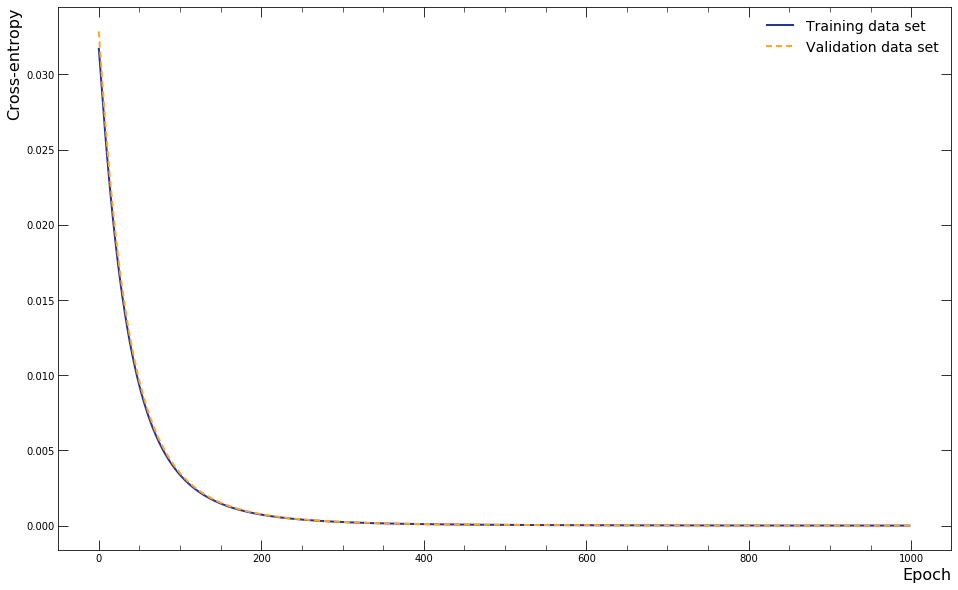

In [11]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

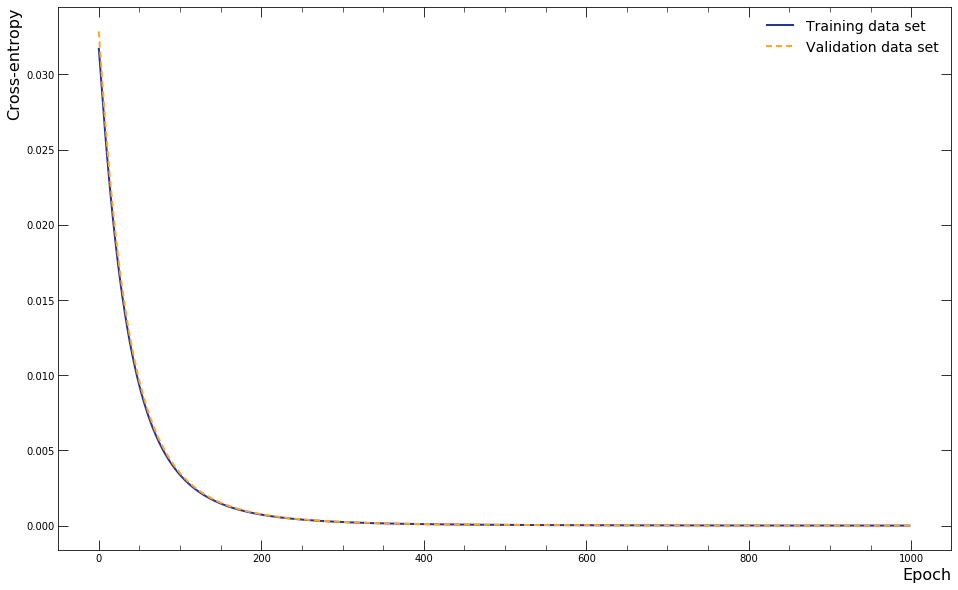

In [12]:
plot_loss(history)

## Training Set

In [13]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = (x_train_new-reconstructed)/x_train_new

In [14]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

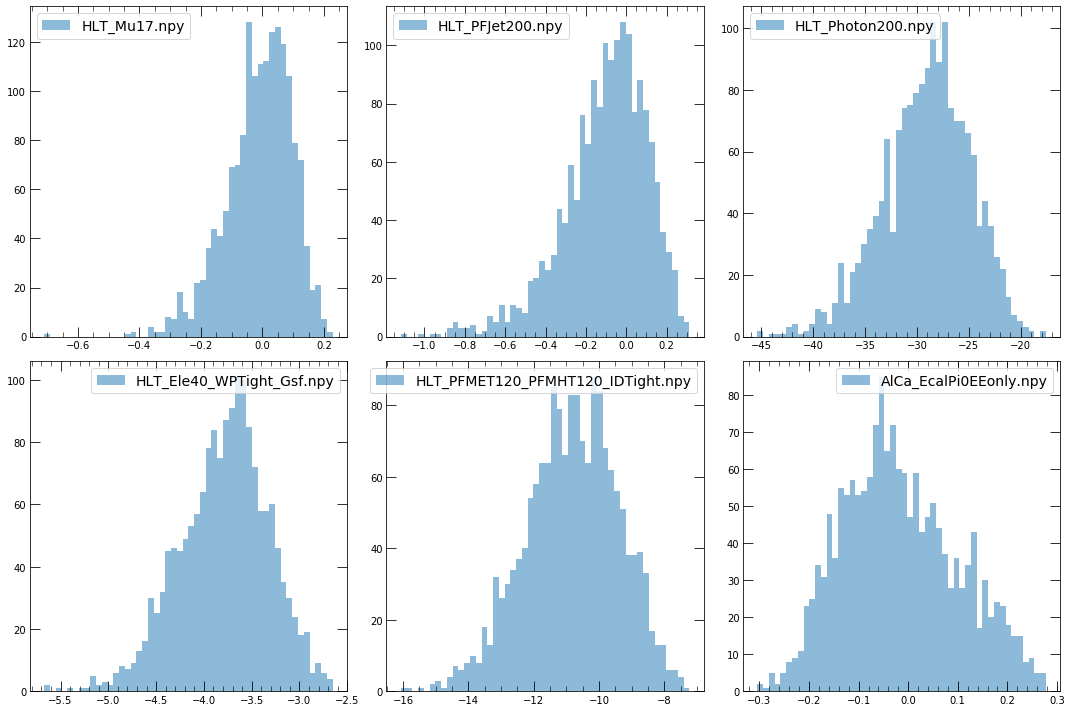

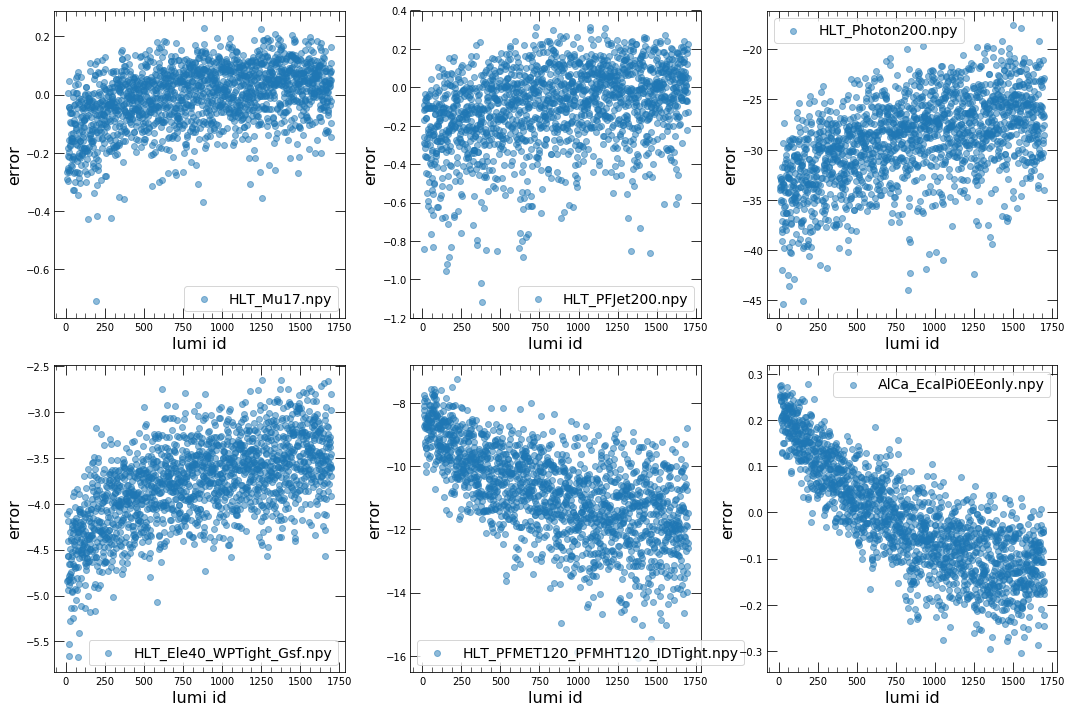

In [15]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()

plt.show()

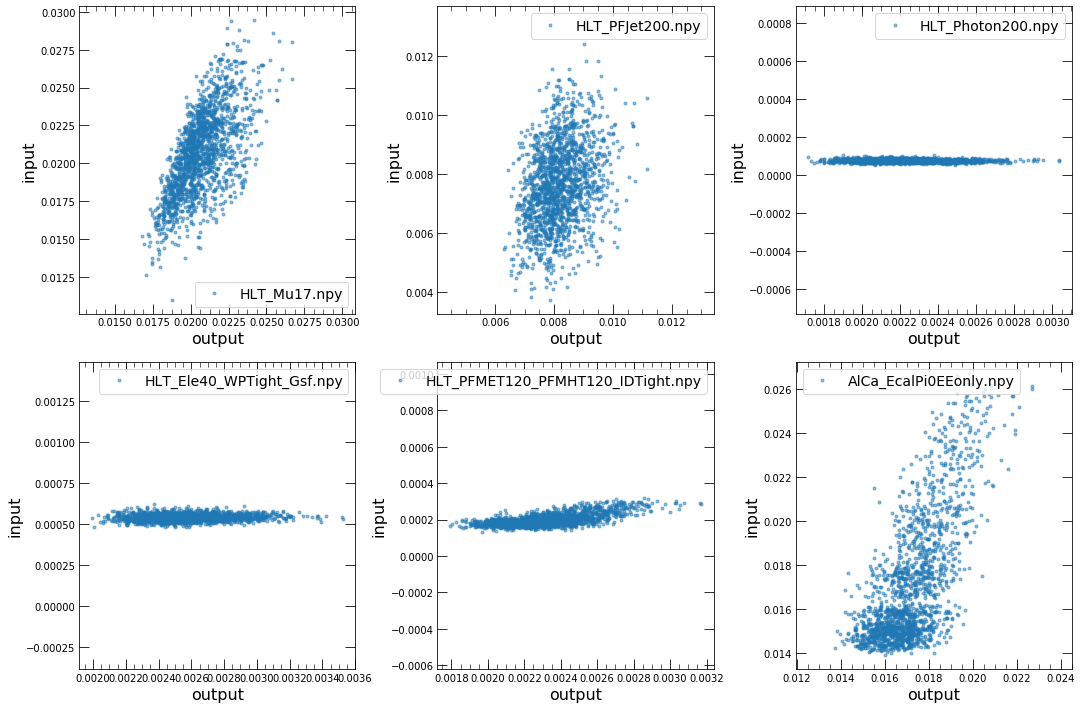

In [16]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    
plt.tight_layout()
plt.show()

## Test Data

In [17]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [18]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

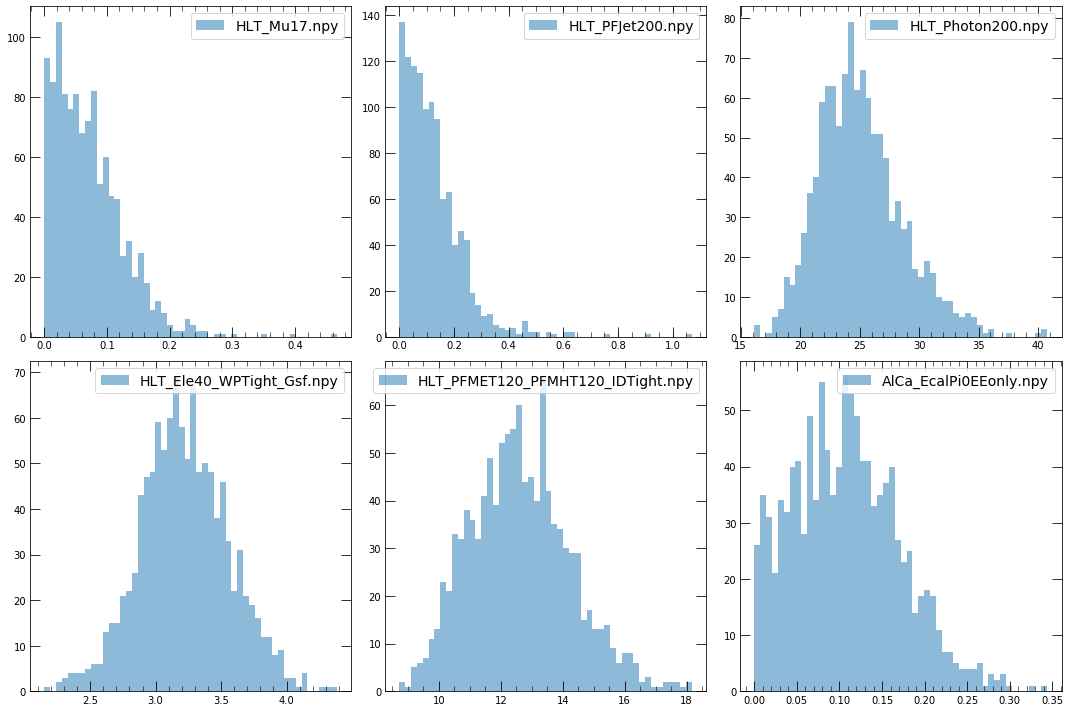

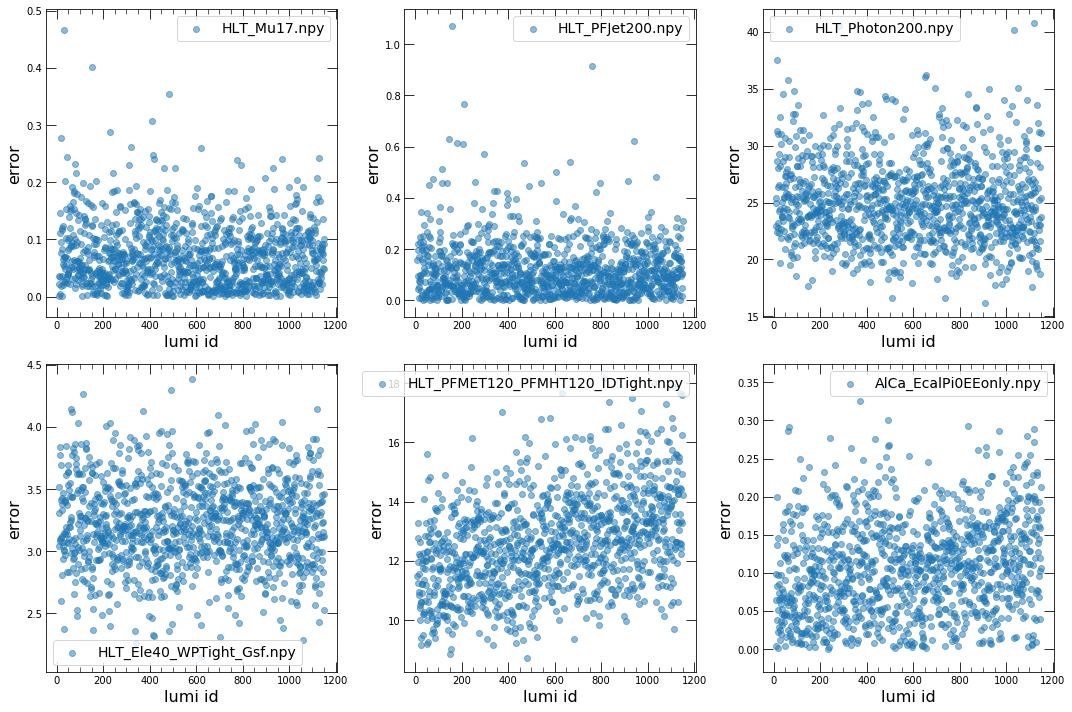

In [19]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()   
plt.tight_layout()

plt.show()

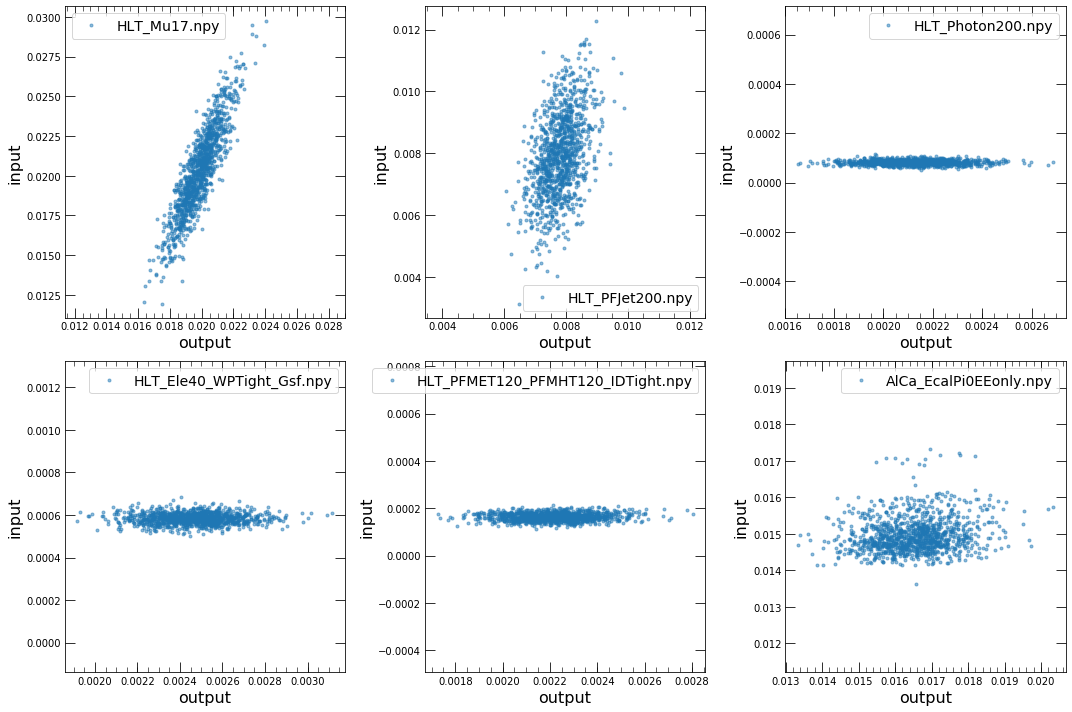

In [20]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    
    
plt.tight_layout()

plt.show()

In [21]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [22]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [23]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [24]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [25]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


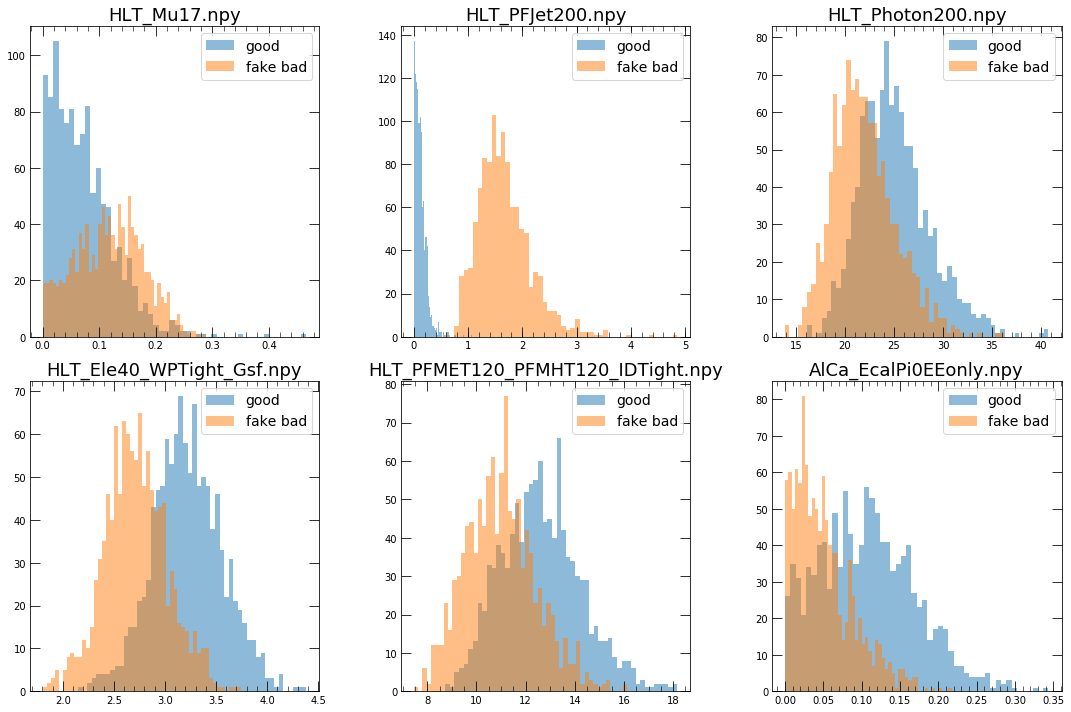

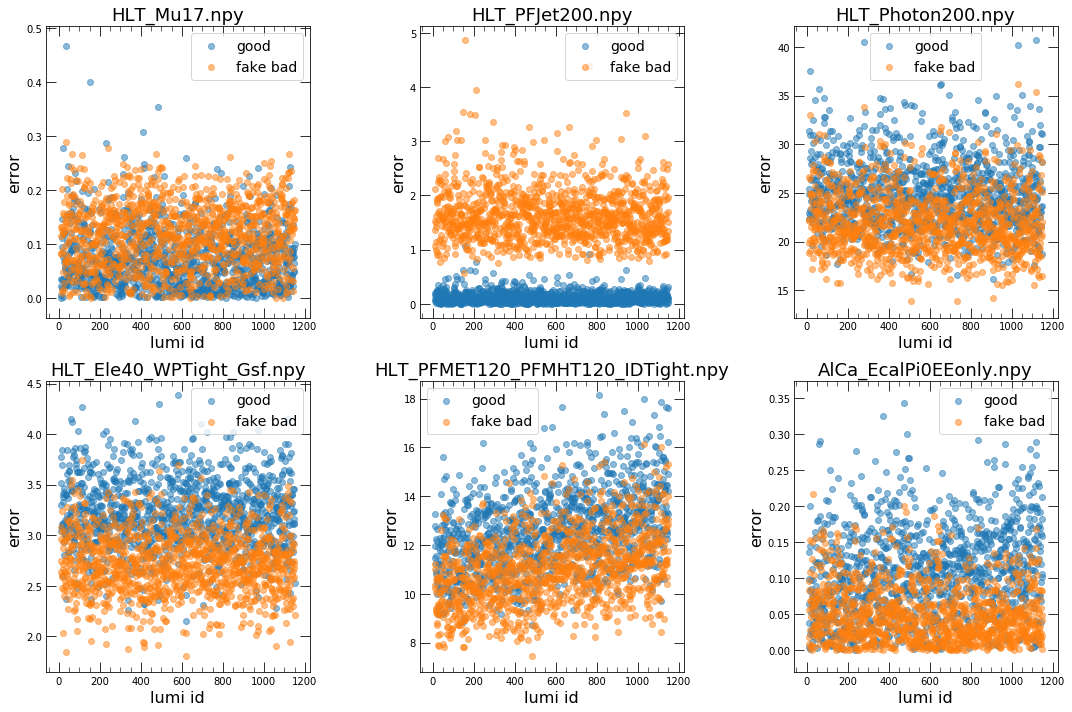

In [26]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

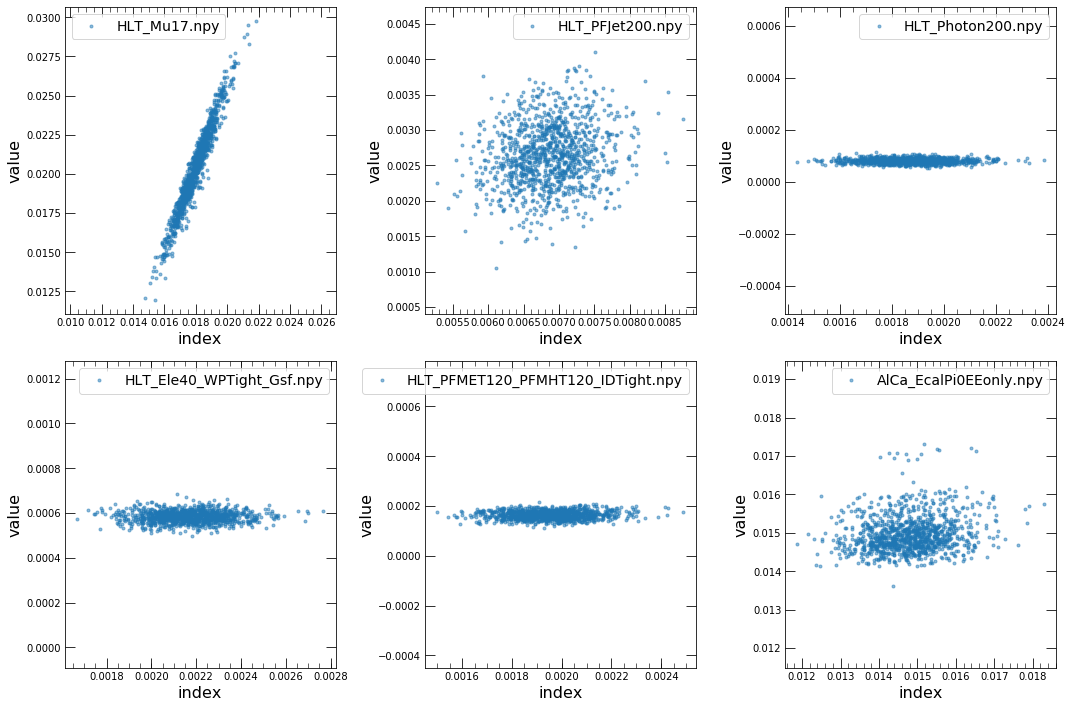

In [27]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [28]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [29]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [30]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [31]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [32]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


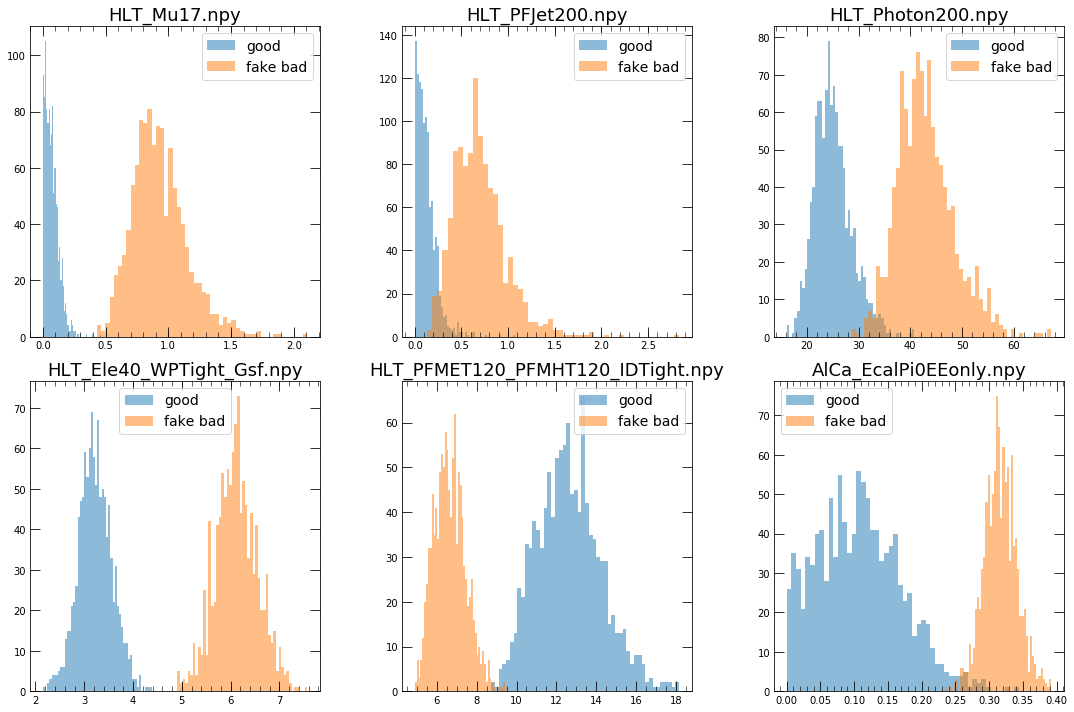

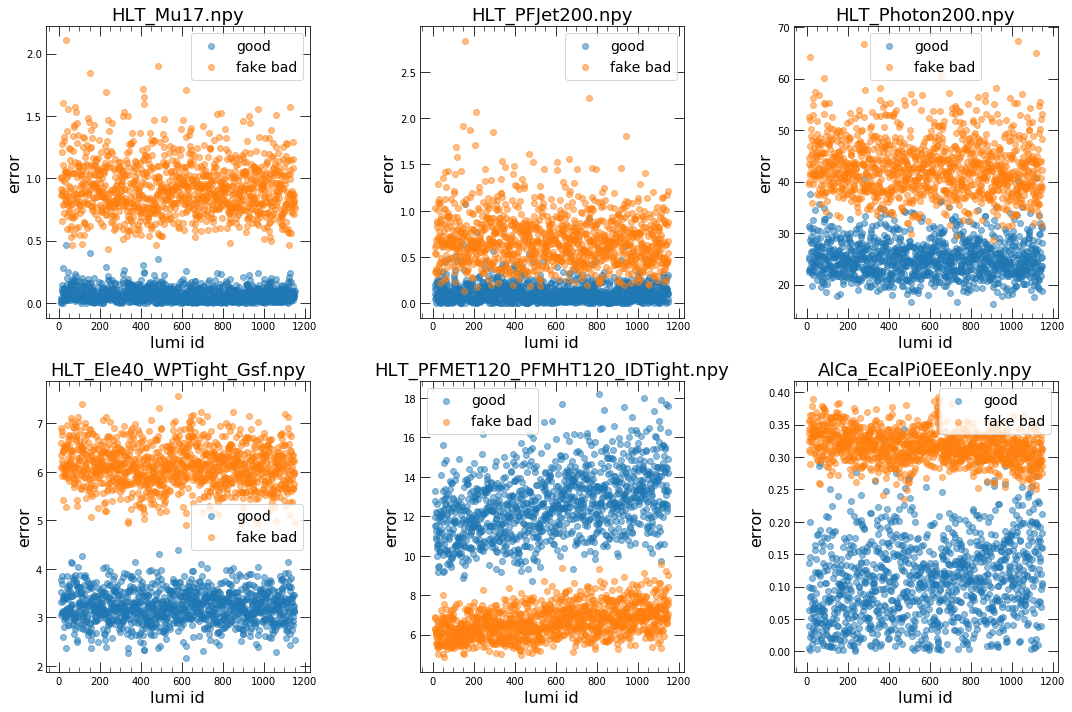

In [33]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

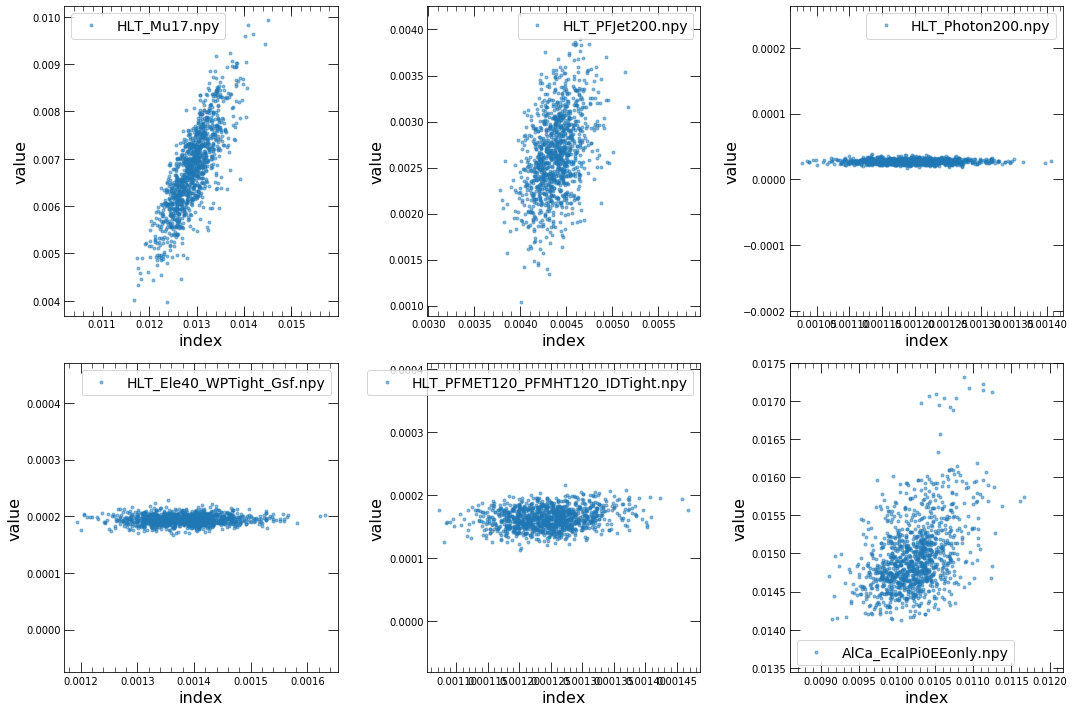

In [34]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [35]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [36]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [37]:
bad_runs = [301480]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [38]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [39]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


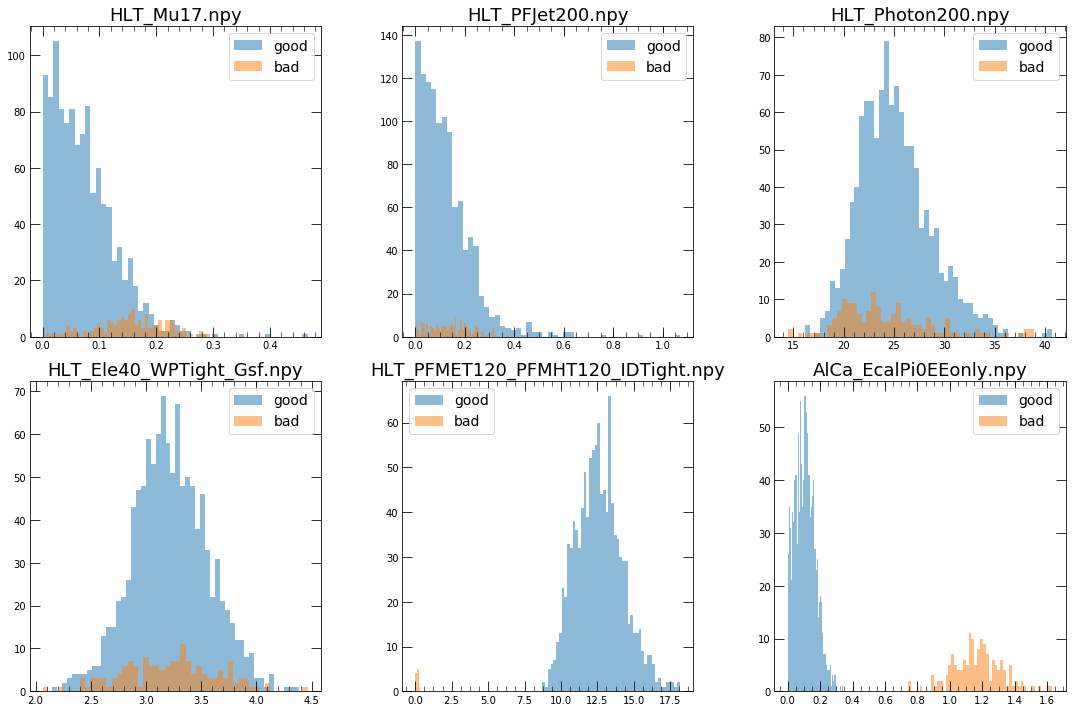

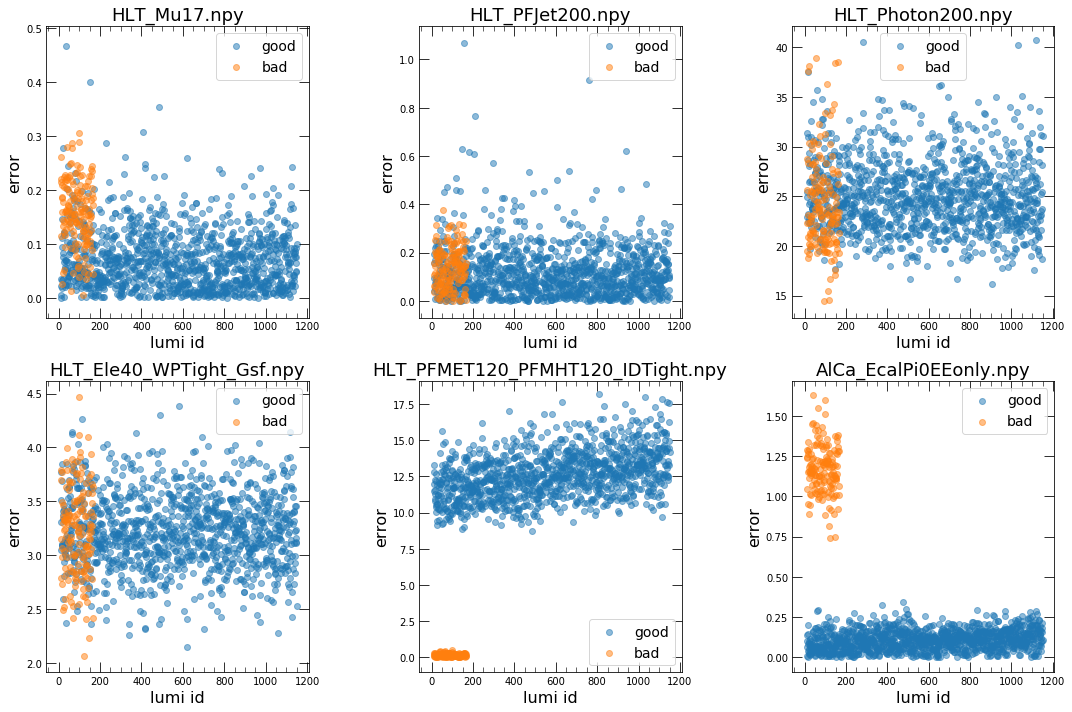

In [40]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

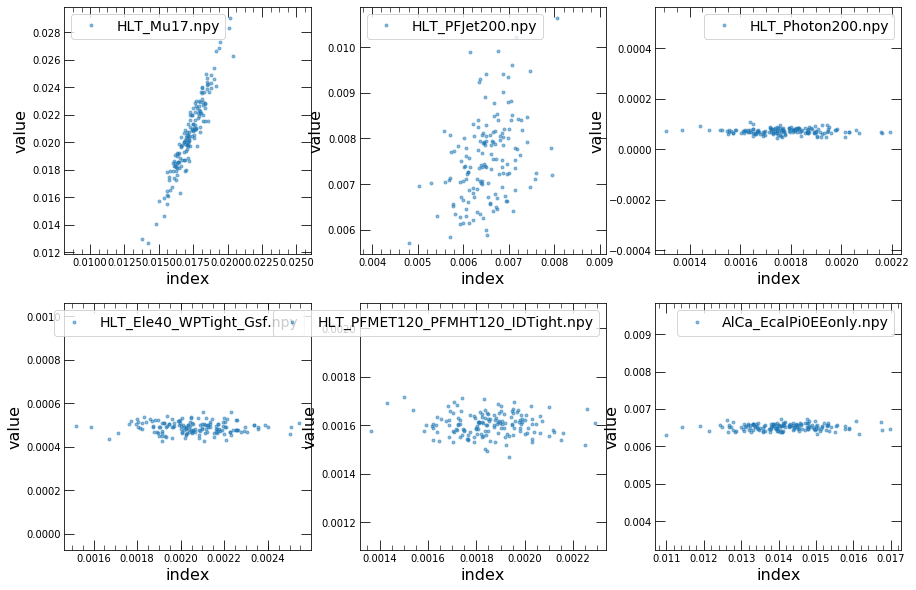

In [41]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [42]:
bad_runs = [305588]

with open("pileup_bad_dataNotNorm.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [43]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [44]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


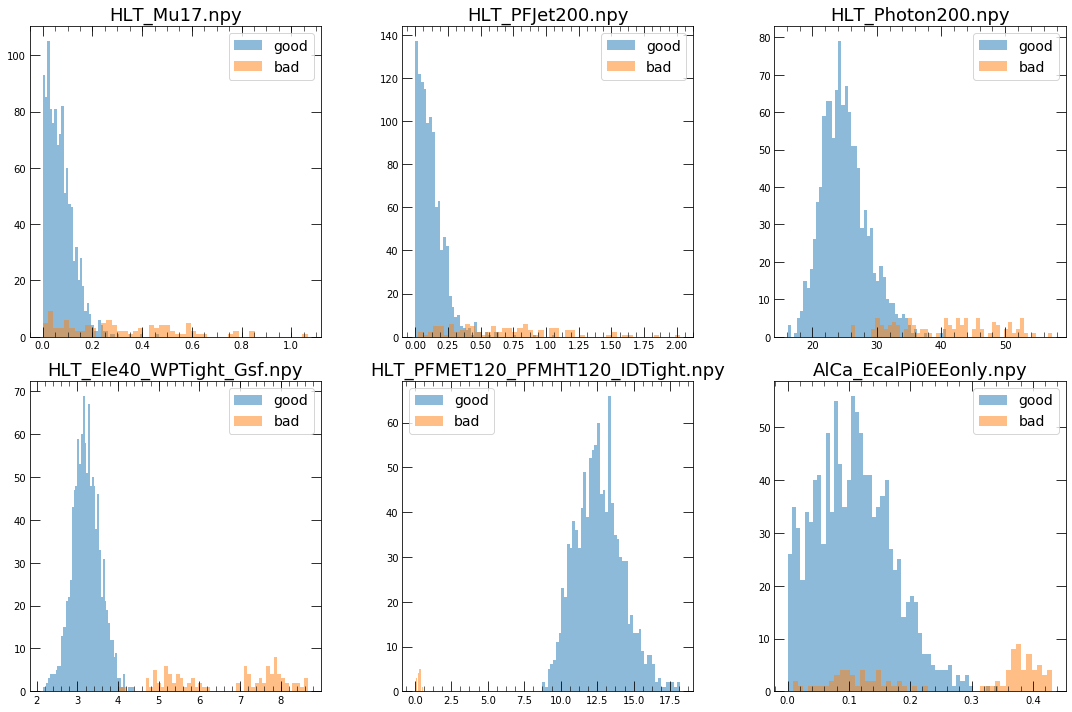

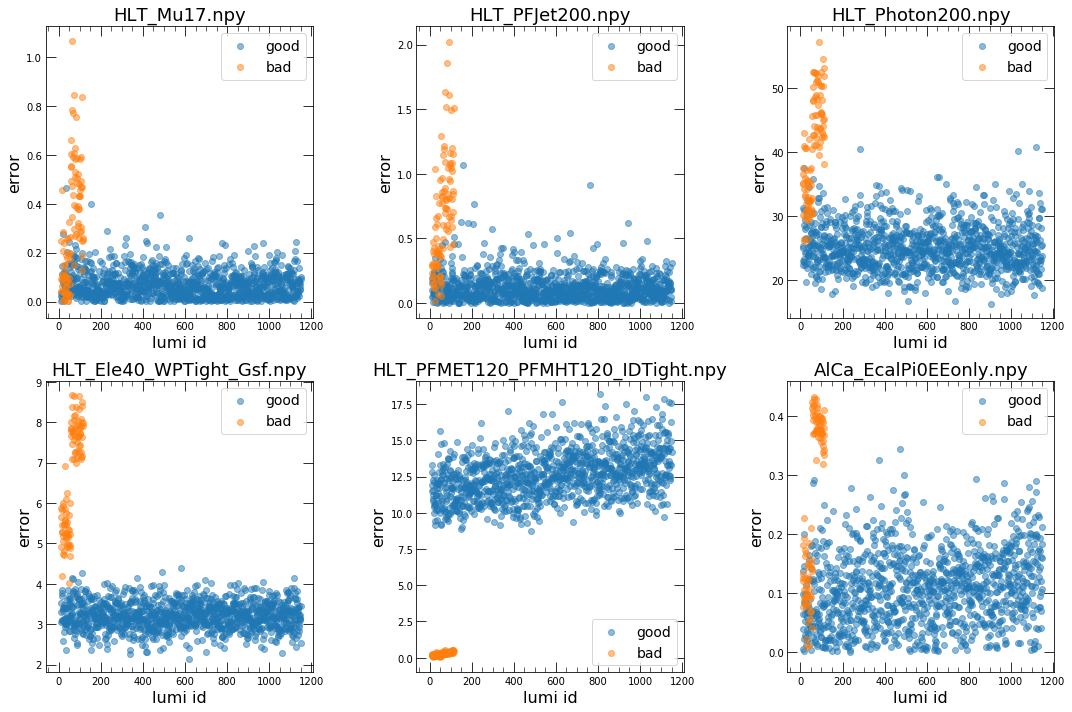

In [45]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

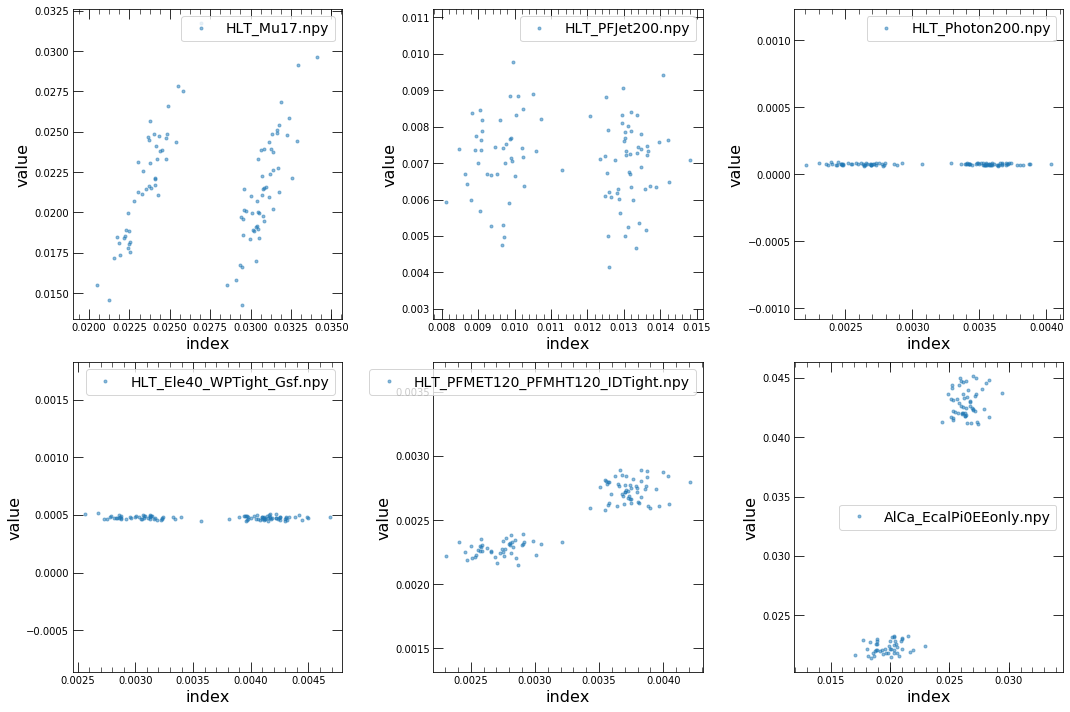

In [46]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()   
plt.tight_layout()

plt.show()